In [1]:
# Degradation Demo:
!pip install --target=$nb_path pzflow
!pip install git+https://github.com/LSSTDESC/RAIL.git#egg=rail[Full]
!git clone https://github.com/COINtoolbox/photoz_catalogues.git 

import matplotlib
matplotlib.use('Agg')
import pylab as pb
from pzflow.examples import example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import InvRedshiftIncompleteness, LineConfusion
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import csv


     |████████████████████████████████| 7.9 MB 15.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pzflow: filename=pzflow-1.7.1-py3-none-any.whl size=7181860 sha256=236db575ff6eff8b45884f2f7b3d1c67e482642c7df9ddeda2efa333edb30f04
  Stored in directory: /root/.cache/pip/wheels/77/5a/38/f20c39240eeff5075e6b33a1afbfa46f065b345e625d10f979
Successfully built pzflow
  Cloning https://github.com/LSSTDESC/RAIL.git to /tmp/pip-install-4z9kpv9f/rail_fe3ca58571c342f1a7467b099e650a32
  Running command git clone -q https://github.com/LSSTDESC/RAIL.git /tmp/pip-install-4z9kpv9f/rail_fe3ca58571c342f1a7467b099e650a32
  Cloning https://github.com/LSSTDESC/DESC_BPZ to /tmp/pip-install-4z9kpv9f/desc-bpz_d16b526352e84d2ca6f44e13ebec7e8a
  Running command git clone -q https://github.com/LSSTDESC/DESC_BPZ /tmp/pip-install-4z9kpv9f/desc-bpz_d16b526352e84d2ca6f44

In [ ]:
import jax.numpy as np
import matplotlib.pyplot as plt

from pzflow import Flow
from pzflow.bijectors import Chain, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data

import pandas as pd

dataPath = '/content/drive/MyDrive/Coding/sdss_sample.csv'
# load the galaxy data
data =loadtxt(open(dataPath,"rb"),delimiter=",")

# convert magnitudes to a reference magnitude and colors
data = data.values
data[:,1], data[:, 2:] = data[:, 3], np.diff(data[:,1:])

# save the new set
data = pd.DataFrame(data, columns=('redshift','r','u-g','g-r','r-i','i-z','z-y'))
data.head()

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
means = data['redshift'].mean()
stds = data['redshift'].std()

# construct our bijector
# by chaining all these layers
bijector = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=1, n_conditions=6),
)


# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns
flow = Flow(data.columns[:1], bijector, conditional_columns=data.columns[1:])

%%time
losses = flow.train(data, epochs=125, verbose=True)

In [ ]:
# plotting the training losses to make sure everything looks like we expect it to
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()


sdss_sample = data[:1]
grid = np.arange(0, 2.02, 0.02)
pdf = flow.posterior(galaxy, column="redshift", grid=grid)

plt.plot(grid, pdf[0], label='Posterior')
plt.axvline(galaxy['redshift'][0], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()


# draw 4 samples for each of the first 500 conditions
samples = flow.sample(4, conditions=data[:500], seed=0)
print(samples.shape)

# lets print the first 10
# see how conditions 0-3 are the same?
# and 4-7? etc.
samples[:10]

samples = flow.sample(1, conditions=data, seed=0)

plt.hist(data['redshift'], range=(0, 2.5), bins=40, histtype='step', label='data')
plt.hist(samples['redshift'], range=(0, 2.5), bins=40, histtype='step', label='samples')
plt.legend()
plt.show()

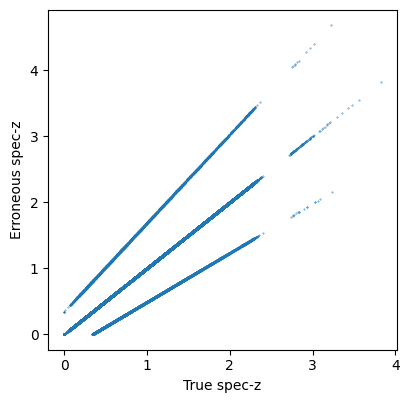

In [ ]:
def OxygenLineConfusion(data, seed=None):
    OII = 3727
    OIII = 5007
    badness = 0
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02*badness)(data, seed)
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01*badness)(data, seed)
    return data

flow = engines.FlowEngine(flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=OxygenLineConfusion)

samples = creator.sample(100000, seed=0)
degraded_samples = degraded_creator.sample(100000, seed=0)

fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.scatter(samples["redshift"], degraded_samples["redshift"], s=0.1)
ax.set(xlabel="True spec-z", ylabel="Erroneous spec-z")
plt.show()
pb.savefig("/content/drive/MyDrive/Coding/Results/OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_degradation.pdf", dpi=300, bbox_inches = "tight")

np.savetxt('/content/drive/MyDrive/Coding/Data/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/badness_0_sdss_samples.csv',samples, delimiter=',')
combined_pdfs=np.genfromtxt('/content/drive/MyDrive/Coding/Data/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/badness_0_sdss_samples.csv', delimiter=',')

np.savetxt('/content/drive/MyDrive/Coding/Data/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/badness_0_sdss_degraded_samples.csv', degraded_samples, delimiter=',')
combined_pdfs=np.genfromtxt('/content/drive/MyDrive/Coding/Data/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/badness_0_sdss_degraded_samples.csv', delimiter=',')


In [ ]:
# Degraded Samples Photo-z:

import matplotlib
matplotlib.use('Agg')
import sys
sys.path.append('/content/drive/MyDrive/Coding')
import GPz
from numpy import *
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pylab as pb
from matplotlib.gridspec import GridSpec

########### Model options ###############

method = 'VC'               # select method, options = GL, VL, GD, VD, GC and VC [required]
                            #
m = 50                      # number of basis functions to use [required]
                            #
joint = True                # jointly learn a prior linear mean function [default=true]
                            #
heteroscedastic = True      # learn a heteroscedastic noise process, set to false interested only in point estimates
                            #
csl_method = 'normal'       # cost-sensitive learning option: [default='normal']
                            #       'balanced':     to weigh rare samples more heavly during train
                            #       'normalized':   assigns an error cost for each sample = 1/(z+1)
                            #       'normal':       no weights assigned, all samples are equally important
                            #
binWidth = 0.1              # the width of the bin for 'balanced' cost-sensitive learning [default=range(z_spec)/100]

decorrelate = True          # preprocess the data using PCA [default=False]

########### Training options ###########

dataPath_samples = '/content/drive/MyDrive/Coding/Data/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/badness_0_sdss_samples.csv'    # path to the data set, has to be in the following format m_1,m_2,..,m_k,e_1,e_2,...,e_k,z_spec
                                        # where m_i is the i-th magnitude, e_i is its associated uncertainty and z_spec is the spectroscopic redshift
                                        # [required]
dataPath_degraded_samples = '/content/drive/MyDrive/Coding/Data/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/badness_0_sdss_degraded_samples.csv'


maxIter = 500                   # maximum number of iterations [default=200]
maxAttempts = 50              # maximum iterations to attempt if there is no progress on the validation set [default=infinity]
trainSplit = 0.2               # percentage of data to use for training
validSplit = 0.2               # percentage of data to use for validation
testSplit  = 0.6               # percentage of data to use for testing

########### Start of script ###########

# Load samples
# read data from file
data = loadtxt(open(dataPath_samples,"rb"),delimiter=",")

X_samples = data[:, 1:6]
n,d = X_samples.shape
Y_samples = data[:, 0].reshape(n, 1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_samples[:, int(filters):] = log(X_samples[:, int(filters):])



# Load degraded_samples
# read data from file
data_2 = loadtxt(open(dataPath_degraded_samples,"rb"),delimiter=",")

X_degraded_samples = data_2[:, 1:6]
n,d = X_degraded_samples.shape
Y_degraded_samples = data_2[:, 0].reshape(n, 1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_degraded_samples[:, int(filters):] = log(X_degraded_samples[:, int(filters):])




# sample training, validation and testing sets from the data
training,validation,testing = GPz.sample(n,trainSplit,validSplit,testSplit)

# you can also select the size of each sample
# training,validation,testing = GPz.sample(n,10000,10000,10000)

# get the weights for cost-sensitive learning
omega = GPz.getOmega(Y_samples, method=csl_method)




# initialize the initial model
model_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_samples.train(X_samples.copy(), Y_samples.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_samples,sigma_samples,modelV_samples,noiseV_samples,_ = model_samples.predict(X_samples[testing,:].copy())




# initialize the initial model
model_degraded_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_degraded_samples.train(X_degraded_samples.copy(), Y_degraded_samples.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_degraded_samples,sigma_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples,_ = model_degraded_samples.predict(X_samples[testing,:].copy())






########### Display Results ###########

# compute metrics   (compared to samples - true redshifts)
rmse_samples = sqrt(GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: (y-mu)**2))
mll_samples  = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: y-mu)



# compute metrics   (compared to samples - true redshifts)
rmse_degraded_samples = sqrt(GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: (y-mu)**2))
mll_degraded_samples  = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: y-mu)




# print metrics for the entire data
print(('{0:4s}\t\t\t{1:3s}\t\t\t{2:6s}\t\t\t{3:6s}\t\t\t{4:4s}'.format('RMSE', ' MLL', ' FR15', ' FR05', ' BIAS')))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_samples[-1], mll_samples[-1], fr15_samples[-1],fr05_samples[-1],bias_samples[-1])))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_degraded_samples[-1], mll_degraded_samples[-1], fr15_degraded_samples[-1],fr05_degraded_samples[-1],bias_degraded_samples[-1])))


Iter	 logML/n 		 Train RMSE		 Train RMSE/n		 Valid RMSE		 Valid MLL		 Time    
   1	-6.0812781e-01	 4.0320961e-01	-5.9043077e-01	 4.1419974e-01	[-6.3687513e-01]	 1.8995473e+00
   2	-4.9551135e-01	 3.5205060e-01	-4.5210565e-01	 3.6612081e-01	[-5.2011307e-01]	 1.8532772e+00
   3	-4.7289562e-01	 3.4064868e-01	-4.3620605e-01	 3.5501726e-01	[-5.1147331e-01]	 1.8631644e+00
   4	-4.6584568e-01	 3.3966092e-01	-4.3012171e-01	 3.5391810e-01	[-5.0455869e-01]	 1.8456426e+00
   5	-4.5378235e-01	 3.3869934e-01	-4.1814849e-01	 3.5296454e-01	[-4.9082256e-01]	 1.2621033e+00
   6	-4.3365119e-01	 3.3755631e-01	-3.9912821e-01	 3.5211990e-01	[-4.7012436e-01]	 1.2435031e+00
   7	-4.0490583e-01	 3.3721197e-01	-3.7575480e-01	 3.5092398e-01	[-4.3758129e-01]	 1.2284713e+00
   8	-3.8765989e-01	 3.4145750e-01	-3.6731893e-01	 3.5531636e-01	[-4.2312990e-01]	 1.2471476e+00
   9	-3.6048303e-01	 3.3837678e-01	-3.4427789e-01	 3.5264508e-01	[-3.9716481e-01]	 1.2568619e+00
  10	-3.4099569e-01	 3.3748544e-01	-3.3141478e-0

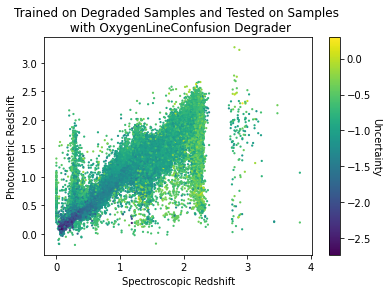

In [ ]:
# plot scatter plots for density and uncertainty
f = plt.figure(1)
plt.scatter(Y_samples[testing,:],mu_samples,s=5, c=np.log10(squeeze(sigma_samples)), edgecolor=['none'])
plt.scatter(Y_samples[testing,:],mu_degraded_samples,s=5, c=np.log10(squeeze(sigma_degraded_samples)), edgecolor=['none'])
cbar = plt.colorbar()
cbar.set_label('Uncertainty', rotation=270, labelpad=10) 
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_1.pdf", dpi=300, bbox_inches = "tight")

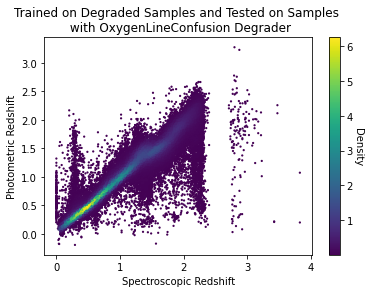

In [ ]:
f = plt.figure(2)
xy_s = hstack([Y_samples[testing,:],mu_samples]).T
xy_ds = hstack([Y_samples[testing,:],mu_degraded_samples]).T

z_s = gaussian_kde(xy_s)(xy_s)
z_ds = gaussian_kde(xy_ds)(xy_ds)
plt.scatter(Y_samples[testing,:],mu_samples,s=5, c=z_s, edgecolor=['none'])
plt.scatter(Y_samples[testing,:],mu_degraded_samples,s=5, c=z_ds, edgecolor=['none'])
cbar = plt.colorbar()
cbar.set_label('Density', rotation=270, labelpad=10)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_2.pdf", dpi=300, bbox_inches = "tight")

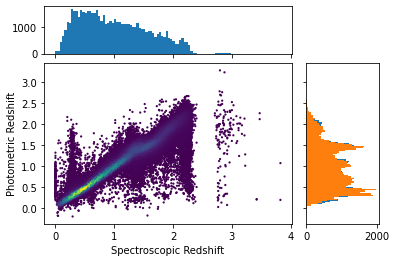

In [ ]:
# marginal histograms of spectroscopic redshifts and photometric redshift estimates
f = plt.figure(2.1)

gs = GridSpec(4,4)

ax_joint = f.add_subplot(gs[1:4,0:3])
ax_marg_x = f.add_subplot(gs[0,0:3])
ax_marg_y = f.add_subplot(gs[1:4,3])

xy_s = hstack([Y_samples[testing,:],mu_samples]).T
xy_ds = hstack([Y_samples[testing,:],mu_degraded_samples]).T
z_s = gaussian_kde(xy_s)(xy_s)
z_ds = gaussian_kde(xy_ds)(xy_ds)

#ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z_s, cmap=plt.cm.viridis, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_degraded_samples, s=5, c=z_ds, cmap=plt.cm.viridis, edgecolor=['none'])
#f.colorbar(im, ax=ax_joint)

ax_marg_x.hist(Y_samples[testing,:], bins=100)
ax_marg_y.hist(mu_samples,orientation="horizontal", bins=100)
ax_marg_y.hist(mu_degraded_samples,orientation="horizontal", bins=100)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Spectroscopic Redshift')
ax_joint.set_ylabel('Photometric Redshift')

# Set labels on marginals
#ax_marg_y.set_xlabel('Marginal x label')
#ax_marg_x.set_ylabel('Marginal y label')

#ax_joint.set_title('2 iterations - Trained on Samples and Tested on Samples', loc='center')

pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_2.1.pdf", dpi=300, bbox_inches = "tight")
#pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_2.2.pdf", dpi=300, bbox_inches = "tight")

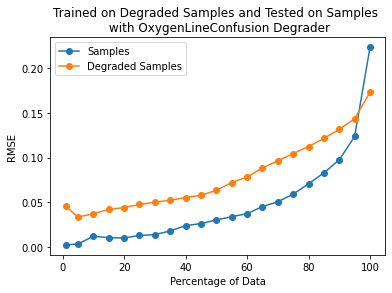

In [ ]:
# plot the change in metrics as functions of data percentage
x = array(list(range(0,20+1)))*5
x[0]=1

ind_s = x*len(rmse_samples) // 100
ind_ds = x*len(rmse_degraded_samples) // 100

f = plt.figure(3)
plt.plot(x,rmse_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,rmse_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('RMSE')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_3_rmse.pdf", dpi=300, bbox_inches = "tight")

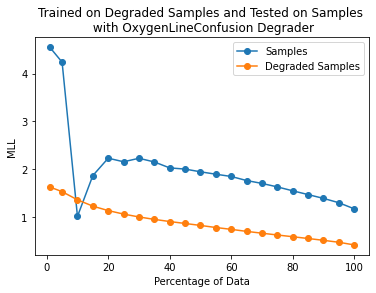

In [ ]:
f = plt.figure(4)
plt.plot(x,mll_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,mll_degraded_samples[ind_ds-1],'o-',  label="Degraded Samples")
plt.legend(loc='upper right')
plt.xlabel('Percentage of Data')
plt.ylabel('MLL')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_4_mll.pdf", dpi=300, bbox_inches = "tight")

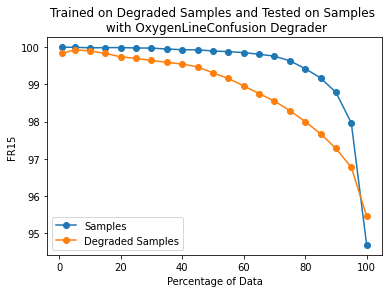

In [ ]:
f = plt.figure(5)
plt.plot(x,fr15_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,fr15_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('FR15')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_5_fr15.pdf", dpi=300, bbox_inches = "tight")

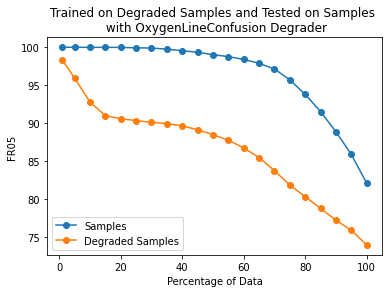

In [ ]:
f = plt.figure(6)
plt.plot(x,fr05_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,fr05_degraded_samples[ind_ds-1],'o-',  label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('FR05')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_6_fr05.pdf", dpi=300, bbox_inches = "tight")

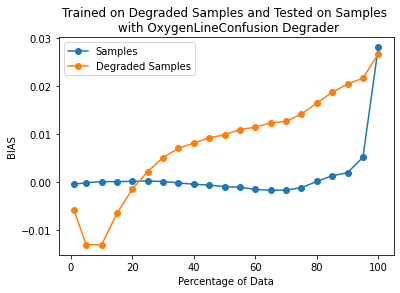

In [ ]:
f = plt.figure(7)
plt.plot(x,bias_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,bias_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('BIAS')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_7_bias.pdf", dpi=300, bbox_inches = "tight")


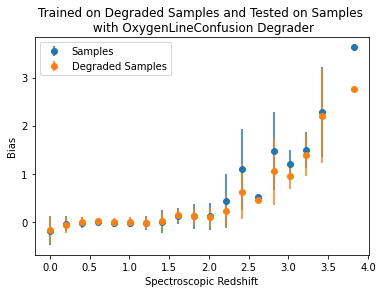

In [ ]:
# plot mean and standard deviation of different scores as functions of spectroscopic redshift using 20 bins
f = plt.figure(8)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_samples,20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_degraded_samples,20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Bias')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_8_bias.pdf", dpi=300, bbox_inches = "tight")

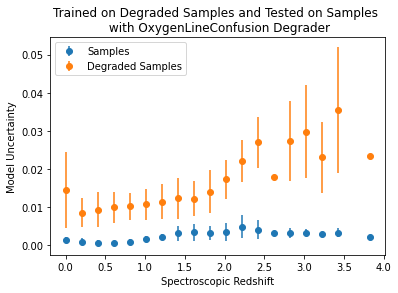

In [ ]:
f = plt.figure(9)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],sqrt(modelV_samples),20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],sqrt(modelV_degraded_samples),20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Model Uncertainty')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_9_modelV.pdf", dpi=300, bbox_inches = "tight")

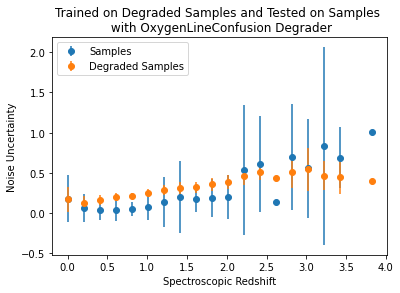

In [ ]:
f = plt.figure(10)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],sqrt(noiseV_samples),20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],sqrt(noiseV_degraded_samples),20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Noise Uncertainty')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_10_noiseV.pdf", dpi=300, bbox_inches = "tight")

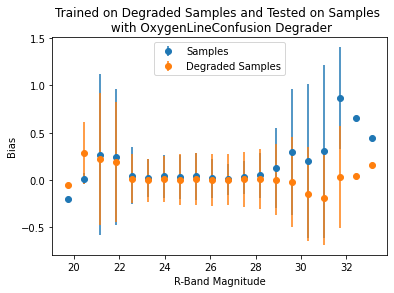

In [ ]:
# plot of bias as a function of magnitude 
f = plt.figure(11)
X_s = data[:, 2].reshape(n,1)
centers_s,means_s,stds_s = GPz.bin(X_s[testing,:], Y_samples[testing,:] - mu_samples, 20)
centers_ds,means_ds,stds_ds = GPz.bin(X_s[testing,:], Y_degraded_samples[testing,:] - mu_degraded_samples, 20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper center')
plt.xlabel('R-Band Magnitude')
plt.ylabel('Bias')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_11.pdf", dpi=300, bbox_inches = "tight")

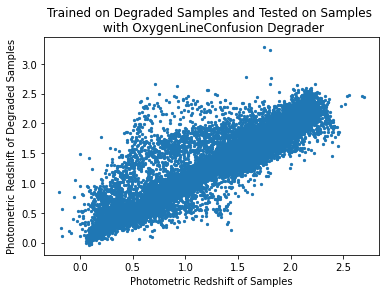

In [ ]:
f = plt.figure(12)
plt.scatter(mu_samples, mu_degraded_samples, s=5)
plt.xlabel('Photometric Redshift of Samples')
plt.ylabel('Photometric Redshift of Degraded Samples')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_12.pdf", dpi=300, bbox_inches = "tight")

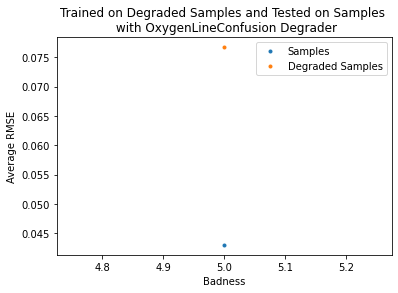

In [ ]:

badness = 5

avg_rmse_samples = sum(rmse_samples) / len(rmse_samples)
avg_rmse_degraded_samples = sum(rmse_degraded_samples) / len(rmse_degraded_samples)

f = plt.figure(13)
plt.plot(badness, avg_rmse_samples,'.', label="Samples")
plt.plot(badness, avg_rmse_degraded_samples,'.', label="Degraded Samples")

plt.legend()
plt.xlabel('Badness')
plt.ylabel('Average RMSE')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_13_aver_rmse_vs_badness.pdf", dpi=300, bbox_inches = "tight")

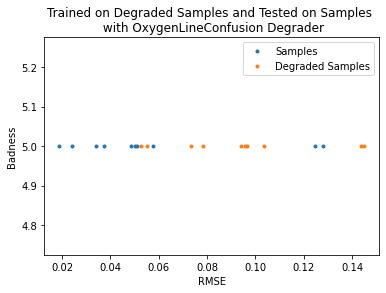

In [ ]:
import numpy as np

idx = np.random.choice(np.arange(len(rmse_samples)), 10, replace=False)
rmse_samples_10 = rmse_samples[idx]
rmse_degraded_samples_10 = rmse_degraded_samples[idx]

badness_no = 5
badness = np.tile(badness_no, 10)

f = plt.figure(14)
plt.plot(rmse_samples_10, badness,'.', label="Samples")
plt.plot(rmse_degraded_samples_10,badness, '.', label="Degraded Samples")
plt.legend()
plt.xlabel('RMSE')
plt.ylabel('Badness')
plt.title('Trained on SDSS Degraded Samples and Tested on SDSS Samples \n with OxygenLineConfusion Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_photoz_14_rmse_vs_badness.pdf", dpi=300, bbox_inches = "tight")

In [ ]:
# save output as a comma seperated values (mean,sigma,model_variance,noise_variance)
savetxt(method+'_'+str(m)+'_'+csl_method+'.csv', array([mu_samples,sigma_samples,modelV_samples,noiseV_samples])[:,:,0].T, delimiter=',')

savetxt(method+'_'+str(m)+'_'+csl_method+'.csv', array([mu_degraded_samples,sigma_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples])[:,:,0].T, delimiter=',')

In [ ]:
# CDETOOLS METRICS CODE

!pip install cde-diagnostics
!pip install cdetools
!pip install corner
!pip install FlexCode
!pip install pzflow
!pip install sklearn
!pip install xgboost==0.90


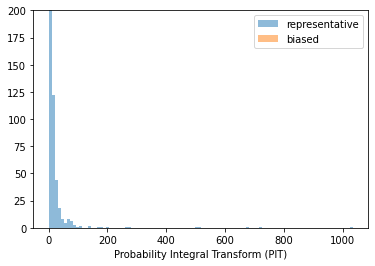

In [ ]:
from cdetools import cde_loss, cdf_coverage, hpd_coverage
from scipy.stats import norm
import numpy as np
import flexcode
# Select regression method
from flexcode.regression_models import NN

n_galaxies = 100000   # from the size of samples
n_grid = 200
z_max = 2
z_min = 0

y_g = np.arange(z_min, z_max, 0.01)
#y_grid = y_g.reshape((200, 1))
y_g_b = np.arange(z_min, z_max, 0.01)
#y_grid_bias =y_g_b.reshape((200, 1))

#Creating a Normal Distribution
def normal_dist(y_g , mu_samples , sigma_samples):
    prob_density = 1/((2*np.pi*sigma_samples**2)**(1/2)) * np.exp(-0.5*((y_g-mu_samples)/sigma_samples)**2)
    return prob_density

cde_test = normal_dist(y_g,mu_samples,sigma_samples)

cde_test_bias = normal_dist(y_g_b, mu_degraded_samples, sigma_degraded_samples)


y_grid = y_g.reshape((200, 1))
y_grid_bias =y_g_b.reshape((200, 1))

Y_samples[testing] = Y_samples[testing].reshape((60000,1))

pit_values = cdf_coverage.cdf_coverage(cde_test, y_grid, Y_samples[testing])
pit_values_bias = cdf_coverage.cdf_coverage(cde_test_bias, y_grid_bias, Y_samples[testing])

plt.hist(pit_values, alpha=0.5, bins=100, label='representative')
plt.hist(pit_values_bias, alpha=0.5, bins=100, label='biased')
plt.ylim(0, 200)
plt.legend()
plt.xlabel('Probability Integral Transform (PIT)')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_cde_PIT.pdf", dpi=300, bbox_inches = "tight")


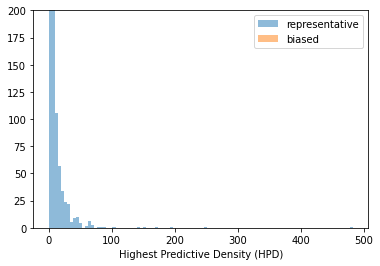

In [ ]:
hpd_cov = hpd_coverage.hpd_coverage(cde_test, y_grid, Y_samples[testing])
hpd_cov_bias = hpd_coverage.hpd_coverage(cde_test_bias, y_grid_bias, Y_samples[testing])

plt.hist(hpd_cov, alpha=0.5, bins=100, label='representative')
plt.hist(hpd_cov_bias, alpha=0.5, bins=100, label='biased')
plt.ylim(0,200)
plt.legend()
plt.xlabel('Highest Predictive Density (HPD)')
pb.savefig("/content/drive/MyDrive/Coding/Results/SDSS_OxygenLineConfusion_degradation+photo-z+cde_metrics/Badness=0/badness_0_sdss_cde_HPD.pdf", dpi=300, bbox_inches = "tight")

In [ ]:
print(cde_loss.cde_loss(cde_test, y_grid, Y_samples[testing]))
print(cde_loss.cde_loss(cde_test_bias, y_grid_bias, Y_samples[testing]))

(7306.831000533756, 2329.08559835877)
(-1.9977569888974152, 0.06292600946487055)


In [ ]:
full_data = {'teddy': teddy}#, 'happy': happy
n_out = 1000

for name, dat in full_data.items():
    for lett in ['A', 'B']:#, 'C', 'D']:
        print(name+lett)
        print(dat[lett].columns)
        dat[lett] = dat[lett][['z_spec', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z']]
        dat[lett] = dat[lett][(dat[lett]['z_spec'] > z_min) & (dat[lett]['z_spec'] < z_max) & (dat[lett]['mag_r'] > r_min) & (dat[lett]['mag_r'] < r_max)]
        dat[lett] = dat[lett].rename(columns={'z_spec': 'redshift', 'mag_r': 'r'})
  
        data = dat[lett].values

    # standard scale the reference magnitude and colors
        data[:, 1:] = (data[:, 1:] - data[:, 1:].mean(axis=0))/data[:, 1:].std(axis=0)

    # calculate the mean and standard deviations of thefrom sklearn.cross_validation import train_test_split dimensions
    # note that on this side of the color transform, we are working
    # in color space, so I calculate the mean and std dev of these 
    # variables instead of the raw magnitudes
        means = data[:, 1:].mean(axis=0)
        stds = data[:, 1:].std(axis=0)

    # save the new set
        data = pd.DataFrame(data, columns=('redshift', 'r', 'u-g', 'g-r', 'r-i', 'i-z'))

    # construct our bijector
  # by chaining all these layers
        bijector = Chain(
          InvSoftplus(column_idx, sharpness),
          StandardScaler(means[column_idx], stds[column_idx]),
          RollingSplineCoupling(nlayers=1, n_conditions=len(data.columns)-1),
        )

  # To create the conditional flow, we have to provide
  # 1. The names of the data columns
  # 2. The bijector
  # 3. The names of the conditional columns
        flow = Flow(data.columns[:1], bijector, conditional_columns=data.columns[1:])

        losses = flow.train(data, epochs=n_epoch, verbose=False)

        samples = flow.sample(1, conditions=data.sample(n_out), seed=0)

        z = samples['redshift']
        z.to_csv(name+lett+'redshifts.csv', index=False)

        phot = samples[['r', 'u-g', 'g-r', 'r-i', 'i-z']]
        phot.to_csv(name+lett+'photometry.csv', index=False)

        posteriors = flow.posterior(samples, column="redshift", grid=grid)
        with open(name+lett+'posteriors.csv', 'wb') as fn:
            jnp.save(fn, posteriors)


In [ ]:
# P = qp.Ensemble(qp.interp, data=dict(xvals=grid.reshape(grid.shape[0]), yvals=posteriors_test))
Q = qp.Ensemble(qp.interp, data=dict(xvals=y_grid.reshape(y_grid.shape[0]), yvals=cde_test))
Q_bias = qp.Ensemble(qp.interp, data=dict(xvals=y_grid.reshape(y_grid_bias.shape[0]), yvals=cde_test_bias))
grid, approx_pdf_on_grid = Q.gridded(grid)
grid, approx_pdf_on_grid_bias = Q_bias.gridded(grid)

In [ ]:
KLDs = np.array([qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1])) for p, q in zip(posteriors_test, approx_pdf_on_grid)])
KLDs_bias = np.array([qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1])) for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)])

plt.hist(np.log(KLDs), alpha=0.5, bins=100, label='representative', density=True)
plt.hist(np.log(KLDs_bias), alpha=0.5, bins=100, label='biased', density=True)
plt.xlabel('KLD')
plt.legend()
plt.semilogy()

In [ ]:
RMSEs = np.array([qp.metrics.quick_rmse(p, q, N=granularity) for p, q in zip(posteriors_test, approx_pdf_on_grid)])
RMSEs_bias = np.array([qp.metrics.quick_rmse(p, q, N=granularity) for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)])

plt.hist(np.log(RMSEs), alpha=0.5, bins=100, label='representative', density=True)
plt.hist(np.log(RMSEs_bias), alpha=0.5, bins=100, label='biased', density=True)
plt.xlabel('RMSE')
plt.legend()